In [1]:
import numpy as np
import cv2
from debayer.superpixel import debayer_superpixel
from astropy.io import fits
from fwhm.star_matcher import StarMatcher
from fwhm.star_finder import StarFinder
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import ICRS
from skymap.skymap import SkyMap
from skymap.stardb.render_view import project
import matplotlib.pyplot as plt
from pathlib import Path


|    | Initial     |    Corrected |
| --- | ---- | --- |
| Albereo |
| RA  | 19h31m39.9612s  | 19h30m52.1928s |
| Dec | 28d00m47.8116s  | 28d02m10.5612 |
| RA  | 19h30m43.2072s  | 19h30m40.8528s |
| Dec | 27d57m35.4204s  | 28d00m37.9908s |
| NGC 7000 |
| RA  | 20h58m46.9452s  | 20h58m50.6532s |
| Dec  | 44d19m48.0612s  | 44d12m19.0872s |
| Crescent Nebula |
| RA  | 20h12m57.7404s  | 20h13m01.7652s |
| Dec | 38d25m36.714s  |  38d30m20.232s |
| Deneb |
| RA  | 20h41m27.2616s  | |
| Dec | 45d16m38.3736s  | |

In [2]:
targets = {
  "Albereo": {
    "location": SkyCoord("19h31m39.9612s", "28d00m47.8116s", frame=ICRS),
    "dir": r"D:\Astro\plate-solving-samples\Albereo\Light"
  },
  "NGC 7000": {
    "location": SkyCoord("20h58m46.9452s", "44d19m48.0612s", frame=ICRS),
    "dir": r"D:\Astro\plate-solving-samples\NGC7000\Light"
  },
  "Crescent Nebula": {
    "location": SkyCoord("20h12m57.7404s", "38d25m36.714s", frame=ICRS),
    "dir": r"D:\Astro\plate-solving-samples\NGC6888\Light"
  },
  "Deneb": {
    "location": SkyCoord("20h41m27.2616s", "45d16m38.3736s", frame=ICRS),
    "dir": r"D:\Astro\plate-solving-samples\Deneb\Light"
  },
  "Alpheratz": {
    "location": SkyCoord("00h08m23.25988s", "+29d05m25.5520s", frame=ICRS),
    "dir": r"D:\Astro\plate-solving-samples\Alpheratz\Light"
  }
}

In [3]:
center = targets["Alpheratz"]["location"]
fname = r"D:/Astro/plate-solving-samples/Alpheratz/Light/Light_03264_10.0sec_300gain_20.4C.fit"
print(center, fname)

<SkyCoord (ICRS): (ra, dec) in deg
    (2.09691617, 29.09043111)> D:/Astro/plate-solving-samples/Alpheratz/Light/Light_03264_10.0sec_300gain_20.4C.fit


In [4]:
# # M101 - EDT115:
# center, fname = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS), r"D:\Astro\20230319-M81M82_M101_M13\Light-M101-300sec\Light_ASIImg_300sec_Bin1_-9.4C_gain200_2023-03-20_023749_frame0026.fit"

# # M101 - C11:
# # center, fname = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS), r"D:\Astro\20230528-M101-Supernova\20230601\M101\Light\Light_02780_180.0sec_300gain_0.0C.fit"
# # center, fname = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS), r"D:\Astro\20230528-M101-Supernova\M101\Light\Light_02650_180.0sec_300gain_-0.3C.fit"
# # center, fname = SkyCoord(14.066564 * u.hour, 54.218594 * u.degree, frame=ICRS), r"D:\Astro\20230528-M101-Supernova\M101\Light\Light_02693_180.0sec_300gain_0.0C.fit"

# # Bubble Nebula - EDT115:
# #center, fname = SkyCoord("23h20m48.3s" "+61d12m06s", frame=ICRS), r"D:\Astro\20230818-uacnj\Bubble\Light\Light_03128_180.0sec_200gain_0.0C.fit"




## Cone search given object sky-coord

In [5]:
import itertools

def cone_search_stardata(skymap: SkyMap, center: SkyCoord, fov_deg: float):
  stars = []
  for star in skymap.coneSearch(center, fov_deg):
    if 'mag' in star and star['mag'] < 11:
      print(star)
      s_coord = SkyCoord(star['ra'] * u.degree, star['dec'] * u.degree, frame=ICRS)
      x, y = project(s_coord.ra.degree, s_coord.dec.degree, center.ra.degree, center.dec.degree, 0)
      stars.append({
        "id": star["_id"], 
        "cluster_cx": x, "cluster_cy": y, 
        "ra": s_coord.ra.degree, "dec": s_coord.dec.degree,
        "mag": star["mag"]
      })
  df_ref = pd.DataFrame(stars)
  return df_ref

with SkyMap() as sm:
  df_ref = cone_search_stardata(sm, center, fov_deg=5.0)

{'_id': 'HD224930*85Peg', 'id': 'HD 224930                          * 85 Peg', 'typ': 'Spectroscopic Binary', 'mag': 5.745384615384616, 'ra': 0.54311966410875, 'dec': 27.081833083809443}
{'_id': 'HD1083HD1083', 'id': 'HD 1083                            HD 1083', 'typ': 'Star', 'mag': 6.3382499999999995, 'ra': 3.79401984767, 'dec': 27.283441223950003}
{'_id': 'HD895HD895', 'id': 'HD 895                             HD 895', 'typ': 'Double or Multiple Star', 'mag': 6.530125, 'ra': 3.34963737946625, 'dec': 26.987494835396944}
{'_id': 'HD434HD434', 'id': 'HD 434                             HD 434', 'typ': 'Spectroscopic Binary', 'mag': 6.556249999999999, 'ra': 2.25067002669, 'dec': 28.24754157053}
{'_id': 'HD225292HD225292', 'id': 'HD 225292                          HD 225292', 'typ': 'Spectroscopic Binary', 'mag': 6.820874999999999, 'ra': 1.2549336969499998, 'dec': 27.67479083913}
{'_id': 'HD167HD167', 'id': 'HD 167                             HD 167', 'typ': 'Star', 'mag': 7.055, 'ra': 1.

In [6]:
df_ref

,id,cluster_cx,cluster_cy,ra,dec,mag
0,HD224930*85Peg,-0.024143,-0.034890,0.543120,27.081833,5.745385
1,HD1083HD1083,0.026321,-0.031343,3.794020,27.283441,6.338250
2,HD895HD895,0.019482,-0.036591,3.349637,26.987495,6.530125
3,HD434HD434,0.002364,-0.014709,2.250670,28.247542,6.556250
4,HD225292HD225292,-0.013014,-0.024659,1.254934,27.674791,6.820875
...,...,...,...,...,...,...
270,GSC01735-01932,-0.030855,-0.022061,0.097784,27.811349,10.975364
271,TYC1736-1759-1,0.021257,-0.006160,3.486003,28.730290,10.980000
272,TYC2259-1270-1,-0.003131,0.028178,1.888278,30.704979,10.985000
273,GSC01736-01628,0.040944,-0.012061,4.764069,28.372811,10.988636


## Plot of stars in the neighborhood

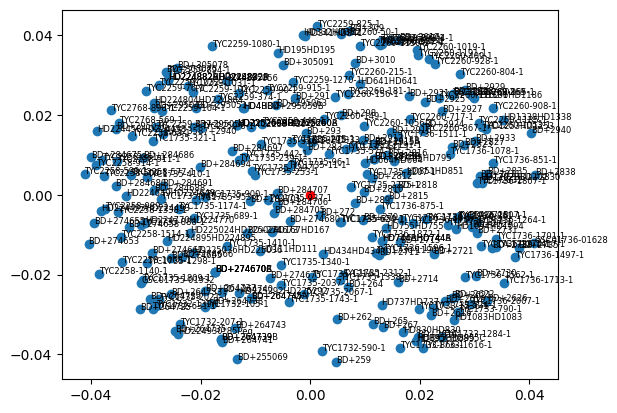

In [7]:
plt.scatter(df_ref.cluster_cx, df_ref.cluster_cy)
for i in range(len(df_ref)):
  r = df_ref.iloc[i]
  plt.annotate(r.id, (r.cluster_cx, r.cluster_cy), fontsize=6)
x, y = project(center.ra.degree, center.dec.degree, center.ra.degree, center.dec.degree, 0)
plt.scatter([x], [y], c='r')

plt.show()

In [8]:
df_ref.head()

,id,cluster_cx,cluster_cy,ra,dec,mag
0,HD224930*85Peg,-0.024143,-0.034890,0.543120,27.081833,5.745385
1,HD1083HD1083,0.026321,-0.031343,3.794020,27.283441,6.338250
2,HD895HD895,0.019482,-0.036591,3.349637,26.987495,6.530125
3,HD434HD434,0.002364,-0.014709,2.250670,28.247542,6.556250
4,HD225292HD225292,-0.013014,-0.024659,1.254934,27.674791,6.820875


## Read image and run star matching

In [9]:

with fits.open(fname) as f:
    ph = f[0]
    img = ph.data
    img = np.expand_dims(img, axis=2)
    # img16 = debayer_superpixel(img)
    img16 = cv2.cvtColor(img, cv2.COLOR_BAYER_BG2BGR) # RGGB pattern

print(img16.mean(), img16.dtype, img16.shape)
assert(img16.dtype == np.uint16)
assert(len(img16.shape) == 3)
assert(img16.shape[2] == 3)
img16 = cv2.cvtColor(img16, cv2.COLOR_BGR2GRAY)
print(img16.mean(), img16.dtype, img16.shape)
img8 = ((img16 / np.iinfo(np.uint16).max) *np.iinfo(np.uint8).max).astype(np.uint8)
print(img8.mean())
numStars = 20
#img8 = cv2.equalizeHist(img8)
star_img, df_tgt = StarFinder().find_stars(img8=np.squeeze(img8), img16=np.squeeze(img16), topk=numStars)

# votes, vVotingPairs = StarMatcher().matchStars(df_ref, df_tgt, return_merged=False)


10243.165137240992 uint16 (2822, 4144, 3)
10955.000390273335 uint16 (2822, 4144)
42.12838667296941


In [10]:
fname

'D:/Astro/plate-solving-samples/Alpheratz/Light/Light_03264_10.0sec_300gain_20.4C.fit'

In [11]:
img.mean()

10711.350520524067

In [12]:
img8.mean()

42.12838667296941

In [13]:
img16.mean()

10955.000390273335

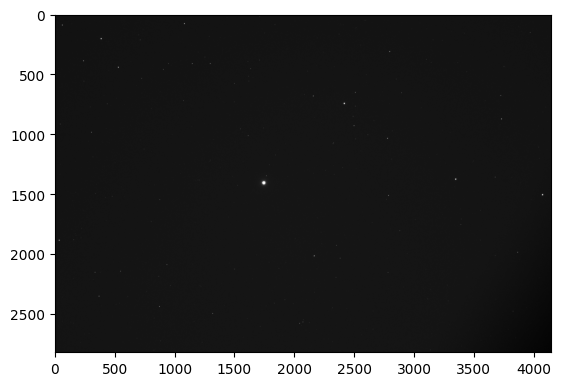

In [14]:
plt.imshow(img8, cmap='gray')

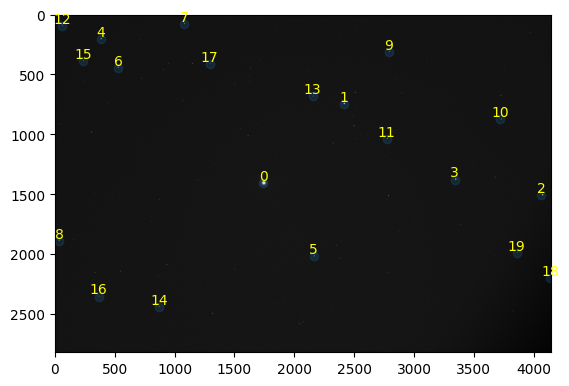

In [15]:
plt.imshow(img8, cmap='gray')
plt.scatter(df_tgt.cluster_cx, df_tgt.cluster_cy, alpha=0.2)
for idx, tgt in df_tgt.iterrows():
  plt.text(tgt.cluster_cx, tgt.cluster_cy, idx, va='bottom', ha='center', c='yellow')

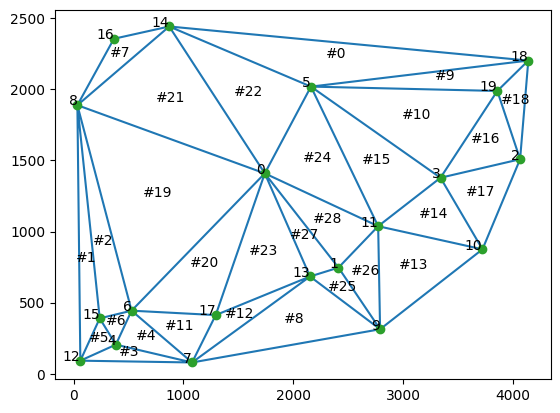

In [16]:
from scipy.spatial import Delaunay
import numpy as np
points = np.array(df_tgt.apply(lambda x: [x.cluster_cx, x.cluster_cy], axis=1).to_list())
tri = Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for j, p in enumerate(points):
    plt.text(p[0]-0.03, p[1]+0.03, j, ha='right') # label the points
for j, s in enumerate(tri.simplices):
    p = points[s].mean(axis=0)
    plt.text(p[0], p[1], f'#{j}', ha='center') # label triangles

plt.show()

In [17]:
m = StarMatcher()

tri_tgt = pd.DataFrame(m._getVertexSortedTriangles(df_tgt, itertools.combinations(df_tgt.index, 3), fov_deg=None))

# tri_ref =  m._getVertexSortedDelaunayTriangles(df_ref, fov_deg=1.0)


# tri_ref = []
# for mag_lim in range(int(df_ref.mag.min())+1, int(df_ref.mag.max())+2, 1):
#   df = df_ref[df_ref.mag <= mag_lim]
#   print(mag_lim, len(df))
#   if len(df) < 3: continue
#   tri_ref.append(m._getVertexSortedDelaunayTriangles(df, fov_deg=1.0))
# tri_ref = pd.concat(tri_ref)


D = None
vTriangles = []
initial_points = []
pt_idx = []
for mag in range(int(df_ref.mag.min()), int(df_ref.mag.max())+1, 1):
  df = df_ref[(df_ref.mag >= mag) & (df_ref.mag < mag+1)]

  points = []
  for idx, r in df.iterrows():
    points.append([r.cluster_cx, r.cluster_cy])
    pt_idx.append(idx)

  if D is None:
    if len(initial_points) < 4:
      initial_points.extend(points)
    
    if len(initial_points) >= 4:
      D = Delaunay(initial_points, incremental=True)
  else:
    D.add_points(points)

    print(mag, len(df))
    if len(df) < 3: continue
    pt_indices = [[pt_idx[x], pt_idx[y], pt_idx[z]] for x,y,z in D.simplices]
    vTriangles.extend(m._getVertexSortedTriangles(df_ref, pt_indices, fov_deg=1.0))

vTriangles = sorted(vTriangles, key=lambda x: x["fX"])
tri_ref = pd.DataFrame(vTriangles)

print(f"Ref triangles: {len(tri_ref)}, Tgt triangles: {len(tri_tgt)}")

7 11
8 22
9 66
10 171
Ref triangles: 670, Tgt triangles: 1140


In [18]:
tri_ref

,A,B,C,fX,fY
0,19,23,79,0.000024,0.999999
1,19,23,79,0.000024,0.999999
2,26,22,21,0.000032,0.999996
3,19,23,14,0.000035,0.999998
4,22,26,179,0.000124,0.999916
...,...,...,...,...,...
665,34,271,110,0.920389,0.977295
666,137,201,199,0.922385,0.936311
667,103,162,238,0.924573,0.972323
668,211,155,186,0.941039,0.950861


In [19]:
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y
0,323,1740.597523,1408.913313,19.000977,18.000977,19.682157,20.711333,"[1720, 1389, 1761, 1428]",365107,5774,28.635016,28.601597
1,284,2411.433099,746.232394,17.000977,17.000977,18.021441,18.578748,"[2393, 728, 2430, 765]",194335,3065,21.566363,21.111002
2,277,4065.303249,1508.350181,15.000977,18.000977,19.020240,16.847532,"[4048, 1489, 4083, 1528]",391588,6237,22.577191,20.420589
3,253,3340.636364,1378.193676,15.000977,17.000977,18.086823,16.695213,"[3324, 1360, 3357, 1397]",358255,5694,22.225064,20.310476
4,195,384.410256,204.815385,13.000977,14.000977,16.019541,14.366164,"[370, 189, 399, 220]",52932,792,17.521371,16.156713
5,137,2160.861314,2019.087591,10.000977,12.000977,12.813568,11.592066,"[2149, 2006, 2172, 2033]",523720,8258,18.646915,15.937189
6,129,527.534884,443.542636,11.000977,11.000977,12.684860,12.563783,"[515, 431, 540, 456]",115128,1836,15.387978,14.773532
7,127,1078.519685,79.299213,11.000977,11.000977,12.443890,12.446729,"[1066, 67, 1091, 92]",20990,294,17.035457,16.399575
8,126,34.079365,1888.507937,10.000977,11.000977,11.986191,11.408866,"[23, 1876, 46, 1901]",489001,7671,14.282699,13.288591
9,104,2790.490385,312.932692,9.000977,10.000977,11.443794,10.357330,"[2780, 301, 2801, 324]",81506,1387,16.855734,15.029283


In [20]:
tri_tgt

,A,B,C,fX,fY
0,15,4,18,0.054842,0.988555
1,15,4,2,0.059175,0.979168
2,15,4,19,0.059625,0.986585
3,4,6,18,0.065434,0.944545
4,15,4,10,0.067064,0.967618
...,...,...,...,...,...
1135,14,15,1,0.937356,0.961465
1136,7,8,5,0.940452,0.959245
1137,4,8,0,0.948261,0.977417
1138,13,11,9,0.967469,0.982001


## Cluster triangles

In [21]:
#TRIANGLETOLERANCE = 1e-3

In [22]:
# ab = tri_tgt.groupby(by=['A', 'B']).agg(list)
# idx = ab.C.apply(len).argmax()
# c = ab.iloc[idx].C
# a,b = ab.index[idx]
# print(a,b,c)
# print(ab.iloc[idx])

# matches = {}
# for ci in c:
#     tgt = tri_tgt[(tri_tgt.A==a)&(tri_tgt.B==b)&(tri_tgt.C==ci)]
#     if len(tgt) > 0:
#         fX, fY = tgt.fX.iloc[0], tgt.fY.iloc[0]
#         s1 = tri_ref[
#             (tri_ref.fX >= fX - TRIANGLETOLERANCE/2) &
#             (tri_ref.fX <= fX + TRIANGLETOLERANCE/2) &
#             (tri_ref.fY >= fY - TRIANGLETOLERANCE/2) &
#             (tri_ref.fY <= fY + TRIANGLETOLERANCE/2)
#         ]
#         s1 = s1.apply(lambda r: set([int(r.A), int(r.B), int(r.C)]), axis=1)
#         if len(s1) > 0:
#             matches[(a,b,ci)] = s1.to_list()

In [23]:
# from collections import defaultdict

# candidates = set()
# match_keys = list(matches.keys())
# print(match_keys)

# for i1 in range(len(match_keys)):
#     (a1, b1, c1) = match_keys[i1]
#     for x in matches[(a1, b1, c1)]:
#         for i2 in range(i1+1, len(match_keys)):
#             (a2, b2, c2) = match_keys[i2]
#             for y in matches[(a2, b2, c2)]:
#                 ix = x.intersection(y)
#                 if len(ix) == 2:
#                     ix = sorted(list(ix))
#                     candidates.add(tuple(ix))

# candidate_counts = defaultdict(int)
# for i1 in range(len(match_keys)):
#     (a1, b1, c1) = match_keys[i1]
#     for x in matches[(a1, b1, c1)]:
#         for y in candidates:
#             ix = x.intersection(y)
#             if len(ix) == 2:
#                 print(i1, x, y)
#                 candidate_counts[y] += 1

In [24]:
# candidate_counts

In [25]:
# plt.scatter(df_ref.cluster_cx, df_ref.cluster_cy)
# for i in range(len(df_ref)):
#   r = df_ref.iloc[i]
#   plt.annotate(r.id, (r.cluster_cx, r.cluster_cy), fontsize=6)


# t = df_ref[df_ref.index.isin([155, 60, 115])]
# plt.scatter(t.cluster_cx, t.cluster_cy, c='r')

# plt.show()

## Triangle matching

In [26]:

from itertools import product

vertex_sorted = True
down_votes = True
absolute_similar = True
vote_with_conf = True


for TRIANGLETOLERANCE in [
        1e-5, 5e-5, 1e-4, 2e-4,
        3e-4, 5e-4, 7e-4, 1e-3,
        2e-3, 5e-3, 7e-3, 1e-2]:
    votes = np.zeros((len(df_ref)+1, len(df_tgt)+1), dtype=np.float32)

    for tgt in tri_tgt.itertuples():
        if absolute_similar:
            similar_triangles = tri_ref[
                (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
                (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2) &
                (tri_ref.fY >= tgt.fY - TRIANGLETOLERANCE/2) &
                (tri_ref.fY <= tgt.fY + TRIANGLETOLERANCE/2)
            ]
        else:
            ref_matches = tri_ref[
                (tri_ref.fX >= tgt.fX - TRIANGLETOLERANCE/2) &
                (tri_ref.fX <= tgt.fX + TRIANGLETOLERANCE/2)]
            similar_triangles = ref_matches[(ref_matches.fX-tgt.fX)**2 + (ref_matches.fY-tgt.fY)**2 < TRIANGLETOLERANCE**2]

        for ref in similar_triangles.itertuples():
            if vote_with_conf:
                err = ((ref.fX-tgt.fX)**2 + (ref.fY-tgt.fY)**2)
                upvote = 1/(np.exp(err*100))
                downvote = upvote / 4
            else:
                upvote = 1
                downvote = 1/4

            if vertex_sorted:
                # expect matched ABC vertices
                votes[ref.A, tgt.A] += upvote
                votes[ref.B, tgt.B] += upvote
                votes[ref.C, tgt.C] += upvote

                if down_votes:
                    votes[ref.A, tgt.B] -= downvote
                    votes[ref.A, tgt.C] -= downvote

                    votes[ref.B, tgt.A] -= downvote
                    votes[ref.B, tgt.C] -= downvote
                    
                    votes[ref.C, tgt.A] -= downvote
                    votes[ref.C, tgt.B] -= downvote
            else:
                # expect unordered star indices s1, s2, s3
                for a,b in product([ref.s1, ref.s2, ref.s3], [tgt.s1, tgt.s2, tgt.s3]):
                    votes[int(a), b] += upvote
    if np.sum(votes) > 10:
        break
    
print(f"TRIANGLETOLERANCE: {TRIANGLETOLERANCE}")
print(f"Total triangle comparisons: {len(tri_ref) * len(tri_tgt)}")
print(f"Total votes: {np.sum(votes)}, hit-ratio: {np.sum(votes) / (len(tri_ref) * len(tri_tgt))}")


TRIANGLETOLERANCE: 0.002
Total triangle comparisons: 763800
Total votes: 23.998329162597656, hit-ratio: 3.141965064493016e-05


In [27]:
with open('votes.csv', 'wt') as f:  
  arr = votes.flatten()
  for i in range(arr.shape[0]):
    f.write(f"{arr[i]}\n")


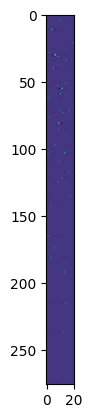

In [28]:
plt.imshow(votes)

(array([1.200e+01, 5.748e+03, 0.000e+00, 2.800e+01, 0.000e+00, 5.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([-0.74990118, -0.27492753,  0.20004611,  0.67501974,  1.14999342,
         1.6249671 ,  2.09994078,  2.57491422,  3.0498879 ,  3.52486157,
         3.99983525]),
 <BarContainer object of 10 artists>)

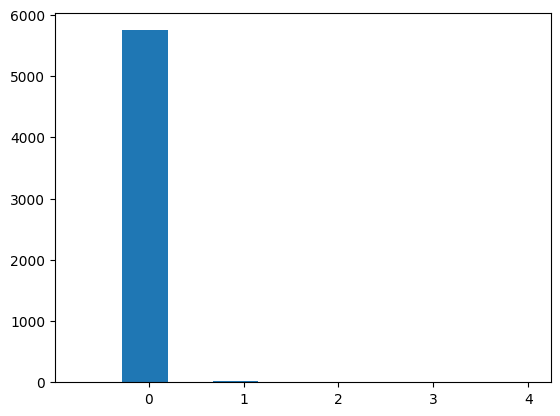

In [29]:
plt.hist(votes.flatten())

In [30]:
# Produce sorted list of star pairs with highest votes
vVotingPairs = np.column_stack(np.unravel_index(np.argsort(votes, axis=None), shape=votes.shape))[::-1]

In [31]:
cutoff = votes.max() / 4
# print(f"Vote cutoff threshold: {cutoff}")
topVotePairs = list(filter(lambda r: votes[r[0],r[1]] > cutoff, vVotingPairs))

matches = []
for vp in topVotePairs:
    s1, s2 = vp
    # if s1 == 0 or s2 == 0: # WHY ?
    #     continue
    if np.argmax(votes[:, s2]) == s1 and np.argmax(votes[s1, :]) == s2:
        matches.append((s1, s2))

df_tgt['starno'] = None
df_tgt['votes'] = None
for m1, m2 in matches:
    df_tgt.loc[m2, 'starno'] = m1
    df_tgt.loc[m2, 'votes'] = votes[m1, m2]

In [32]:
d = []
# n = []
for i in range(len(df_tgt)):
    m = votes[:,i]
    ave = (m.sum() - m.max())/(len(m)-1)
    d.append((m.max()-ave)/ave)
    # n.append(len(np.argwhere(m > 2 * ave)))
print(d)
# print(n)
# plt.plot(m)
# plt.plot(np.arange(0, len(m)), np.full(len(m), ave))


[-550.9999672153974, 549.0200970739637, -21865244.483412325, -9028280.060665362, -550.9999672163668, -550.9999672158274, -1101.0039996509395, nan, -30153801.326797385, 6892120.215139442, 7899315.609589042, -826.0039016565557, -13069795.12181303, -1101.0076064412967, 549.0866262351288, nan, -6054694.766404199, -551.0000327837506, nan, -550.9999672140685]


C:\Users\anand\AppData\Local\Temp\ipykernel_18456\408611718.py:6: RuntimeWarning: invalid value encountered in scalar divide
  d.append((m.max()-ave)/ave)


## Matched stars

In [33]:
# display(df_tgt[~df_tgt.starno.isnull()])
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes
0,323,1740.597523,1408.913313,19.000977,18.000977,19.682157,20.711333,"[1720, 1389, 1761, 1428]",365107,5774,28.635016,28.601597,None,None
1,284,2411.433099,746.232394,17.000977,17.000977,18.021441,18.578748,"[2393, 728, 2430, 765]",194335,3065,21.566363,21.111002,62,0.999968
2,277,4065.303249,1508.350181,15.000977,18.000977,19.020240,16.847532,"[4048, 1489, 4083, 1528]",391588,6237,22.577191,20.420589,28,0.999964
3,253,3340.636364,1378.193676,15.000977,17.000977,18.086823,16.695213,"[3324, 1360, 3357, 1397]",358255,5694,22.225064,20.310476,None,None
4,195,384.410256,204.815385,13.000977,14.000977,16.019541,14.366164,"[370, 189, 399, 220]",52932,792,17.521371,16.156713,11,1.999934
5,137,2160.861314,2019.087591,10.000977,12.000977,12.813568,11.592066,"[2149, 2006, 2172, 2033]",523720,8258,18.646915,15.937189,40,1.999901
6,129,527.534884,443.542636,11.000977,11.000977,12.684860,12.563783,"[515, 431, 540, 456]",115128,1836,15.387978,14.773532,30,3.999835
7,127,1078.519685,79.299213,11.000977,11.000977,12.443890,12.446729,"[1066, 67, 1091, 92]",20990,294,17.035457,16.399575,None,None
8,126,34.079365,1888.507937,10.000977,11.000977,11.986191,11.408866,"[23, 1876, 46, 1901]",489001,7671,14.282699,13.288591,31,1.999912
9,104,2790.490385,312.932692,9.000977,10.000977,11.443794,10.357330,"[2780, 301, 2801, 324]",81506,1387,16.855734,15.029283,81,2.999605


##  Solved or not

In [34]:
print(f"Solver votes: {df_tgt.votes.sum()}; matches: {(~df_tgt.starno.isnull()).sum()} stars")

if (~df_tgt.starno.isnull()).sum() >= 3:
  print("Solved")
else:
  print("Failed")

Solver votes: 25.99819040298462; matches: 14 stars
Solved


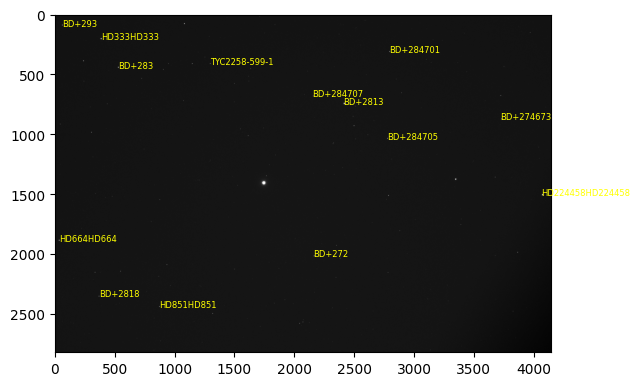

In [35]:
plt.imshow(img8, cmap='gray')
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
    # print(star.starno, (star.cluster_cx, star.cluster_cy))
    plt.annotate(df_ref.loc[star.starno].id, (star.cluster_cx, star.cluster_cy), fontsize=6, color='yellow')

## Calculate transformation matrix
From known star mapping to image, compute affine transformation to map database projection to image

In [36]:
img_stars = df_tgt[~df_tgt.starno.isnull()][['starno','cluster_cx', 'cluster_cy', 'votes']]
img_ref_stars = df_ref[['id','cluster_cx', 'cluster_cy', 'ra', 'dec']].join(img_stars.set_index('starno'), rsuffix='r', how='right')
display(img_ref_stars)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
62,BD+2813,0.011670,0.008973,2.865972,29.602380,2411.433099,746.232394,0.999968
28,HD224458HD224458,-0.038855,0.015891,359.526035,29.976639,4065.303249,1508.350181,0.999964
11,HD333HD333,-0.001419,0.013039,2.003176,29.837510,384.410256,204.815385,1.999934
40,BD+272,0.001866,-0.005068,2.218926,28.800020,2160.861314,2019.087591,1.999901
30,BD+283,-0.000606,0.011202,2.056912,29.732275,527.534884,443.542636,3.999835
31,HD664HD664,0.010004,0.008057,2.755805,29.550458,34.079365,1888.507937,1.999912
81,BD+284701,-0.010877,-0.001633,1.384387,28.994966,2790.490385,312.932692,2.999605
59,BD+274673,-0.011452,-0.009505,1.349938,28.543725,3722.699029,875.116505,1.999769
55,BD+284705,-0.006522,-0.004561,1.670369,28.828453,2772.906977,1037.488372,2.999605


In [37]:
matched_star_triple = img_ref_stars.sort_values('votes', ascending=False)[:3]
display(matched_star_triple)

,id,cluster_cx,cluster_cy,ra,dec,cluster_cxr,cluster_cyr,votes
starno,,,,,,,,
30,BD+283,-0.000606,0.011202,2.056912,29.732275,527.534884,443.542636,3.999835
81,BD+284701,-0.010877,-0.001633,1.384387,28.994966,2790.490385,312.932692,2.999605
55,BD+284705,-0.006522,-0.004561,1.670369,28.828453,2772.906977,1037.488372,2.999605


In [38]:
src = np.array([(row.cluster_cx, row.cluster_cy) for _, row in matched_star_triple.iterrows()], dtype=np.float32)
dst = np.array([(row.cluster_cxr, row.cluster_cyr) for _, row in matched_star_triple.iterrows()], dtype=np.float32)

In [39]:
import cv2
tx = cv2.getAffineTransform(src, dst)
print(tx)

[[ -79684.34286271 -112543.0764815     1739.94808413]
 [ 112632.42651028  -79950.81525495    1407.45188802]]


## Apply transform with dot-product

In [40]:
df_ref[['img_cx', 'img_cy']] = df_ref.apply(lambda r: pd.Series(np.dot(tx, [r.cluster_cx, r.cluster_cy, 1])).astype(np.int32), axis=1)

## Applyig transform with cv2.transform

In [41]:
# pts = np.array([[(r.cluster_cx, r.cluster_cy) for _,r in df_ref.iterrows()]], dtype=np.float32)
# print(pts[0,0,:])
# tx_pts = cv2.transform(pts, tx)
# print(tx_pts[0,0,:])
# print(pts.shape, tx_pts.shape)
# display(np.hstack([pts[0], tx_pts[0]])[0:5])

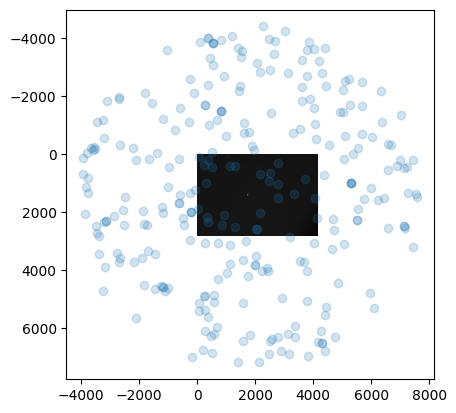

In [42]:
# pts = tx * pts
plt.imshow(img8, cmap='gray')
# plt.scatter(tx_pts[0, :, 0], tx_pts[0, :, 1], alpha=0.2)
plt.scatter(df_ref.img_cx, df_ref.img_cy, alpha=0.2)

# Reassign stars


In [43]:

def dist(x1,y1, x2,y2):
  return np.sqrt((y2-y1)**2+(x2-x1)**2)
def reassign(t):
  x = df_ref.apply(lambda r: pd.Series([dist(t.cluster_cx, t.cluster_cy, r.img_cx, r.img_cy)]), axis=1)[0]
  m = x.min()
  if m < 25:
    return x.argmin()
  else:
    return None
df_tgt['starno'] = df_tgt.apply(reassign, axis=1)


In [44]:
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes
0,323,1740.597523,1408.913313,19.000977,18.000977,19.682157,20.711333,"[1720, 1389, 1761, 1428]",365107,5774,28.635016,28.601597,NaN,None
1,284,2411.433099,746.232394,17.000977,17.000977,18.021441,18.578748,"[2393, 728, 2430, 765]",194335,3065,21.566363,21.111002,NaN,0.999968
2,277,4065.303249,1508.350181,15.000977,18.000977,19.020240,16.847532,"[4048, 1489, 4083, 1528]",391588,6237,22.577191,20.420589,16.0,0.999964
3,253,3340.636364,1378.193676,15.000977,17.000977,18.086823,16.695213,"[3324, 1360, 3357, 1397]",358255,5694,22.225064,20.310476,5.0,None
4,195,384.410256,204.815385,13.000977,14.000977,16.019541,14.366164,"[370, 189, 399, 220]",52932,792,17.521371,16.156713,11.0,1.999934
5,137,2160.861314,2019.087591,10.000977,12.000977,12.813568,11.592066,"[2149, 2006, 2172, 2033]",523720,8258,18.646915,15.937189,40.0,1.999901
6,129,527.534884,443.542636,11.000977,11.000977,12.684860,12.563783,"[515, 431, 540, 456]",115128,1836,15.387978,14.773532,30.0,3.999835
7,127,1078.519685,79.299213,11.000977,11.000977,12.443890,12.446729,"[1066, 67, 1091, 92]",20990,294,17.035457,16.399575,NaN,None
8,126,34.079365,1888.507937,10.000977,11.000977,11.986191,11.408866,"[23, 1876, 46, 1901]",489001,7671,14.282699,13.288591,31.0,1.999912
9,104,2790.490385,312.932692,9.000977,10.000977,11.443794,10.357330,"[2780, 301, 2801, 324]",81506,1387,16.855734,15.029283,81.0,2.999605


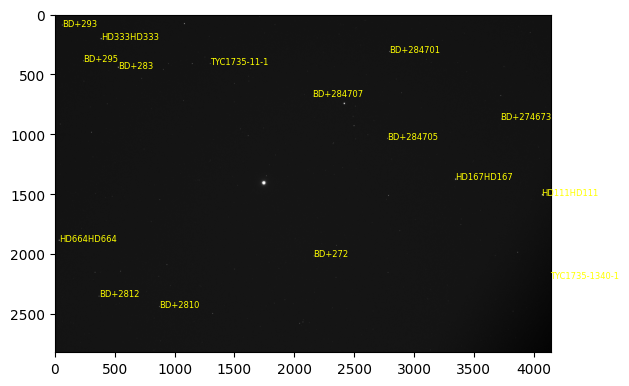

In [45]:
plt.imshow(img8, cmap='gray')
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
    # print(star.starno, (star.cluster_cx, star.cluster_cy))
    plt.annotate(df_ref.loc[star.starno].id, (star.cluster_cx, star.cluster_cy), fontsize=6, color='yellow')

## Map pixel coordinated to RA,DEC
Use linear regression to fit a function to map pixel coordinates to RA,DEC.
Useful to find RA, DEC of image center.

In [46]:
from sklearn.linear_model import LinearRegression
X = df_ref[['img_cx', 'img_cy']]
y = df_ref[['ra', 'dec']]
reg = LinearRegression().fit(X, y)
pred_center = reg.predict([[img8.shape[1]//2, img8.shape[0]//2]])[0]
pred_center = SkyCoord(pred_center[0] * u.degree, pred_center[1] * u.degree, frame=ICRS)
print(f"Image Center RA,DEC: {pred_center}")
print(f"Separation from target: {center.separation(pred_center).arcminute}")

Image Center RA,DEC: <SkyCoord (ICRS): (ra, dec) in deg
    (34.33956534, 28.96880437)>
Separation from target: 1686.1528879403338


c:\Users\anand\anaconda3\envs\astro\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [47]:
df_tgt['name'] = None
for idx, star in df_tgt[~df_tgt.starno.isnull()].iterrows():
  df_tgt.loc[idx, 'name'] = df_ref.loc[star.starno].id

In [48]:
df_tgt

,area,cluster_cx,cluster_cy,iwc_cx,iwc_cy,gaussian_cx,gaussian_cy,box,tile_4,tile_32,fwhm_x,fwhm_y,starno,votes,name
0,323,1740.597523,1408.913313,19.000977,18.000977,19.682157,20.711333,"[1720, 1389, 1761, 1428]",365107,5774,28.635016,28.601597,NaN,None,None
1,284,2411.433099,746.232394,17.000977,17.000977,18.021441,18.578748,"[2393, 728, 2430, 765]",194335,3065,21.566363,21.111002,NaN,0.999968,None
2,277,4065.303249,1508.350181,15.000977,18.000977,19.020240,16.847532,"[4048, 1489, 4083, 1528]",391588,6237,22.577191,20.420589,16.0,0.999964,HD111HD111
3,253,3340.636364,1378.193676,15.000977,17.000977,18.086823,16.695213,"[3324, 1360, 3357, 1397]",358255,5694,22.225064,20.310476,5.0,None,HD167HD167
4,195,384.410256,204.815385,13.000977,14.000977,16.019541,14.366164,"[370, 189, 399, 220]",52932,792,17.521371,16.156713,11.0,1.999934,HD333HD333
5,137,2160.861314,2019.087591,10.000977,12.000977,12.813568,11.592066,"[2149, 2006, 2172, 2033]",523720,8258,18.646915,15.937189,40.0,1.999901,BD+272
6,129,527.534884,443.542636,11.000977,11.000977,12.684860,12.563783,"[515, 431, 540, 456]",115128,1836,15.387978,14.773532,30.0,3.999835,BD+283
7,127,1078.519685,79.299213,11.000977,11.000977,12.443890,12.446729,"[1066, 67, 1091, 92]",20990,294,17.035457,16.399575,NaN,None,None
8,126,34.079365,1888.507937,10.000977,11.000977,11.986191,11.408866,"[23, 1876, 46, 1901]",489001,7671,14.282699,13.288591,31.0,1.999912,HD664HD664
9,104,2790.490385,312.932692,9.000977,10.000977,11.443794,10.357330,"[2780, 301, 2801, 324]",81506,1387,16.855734,15.029283,81.0,2.999605,BD+284701
